# Offline Machine-Learning Example

## Methodology

There are $M$ assets in the investment universe. We parametrize allocations to assets in the portfolio with a neural network. Portfolio return over period from $t$ to $t+1$ is

$$ r_{t+1}^{(p)} = \mathscr{N}(x_{t})^T r_{t+1}$$

where $x_{t}$ is the feature vector at time $t$, $\mathscr{N}(.)$ is a neural network producing $M-$dimensional simplex as output and $r_{t+1}$ is $M-$ dimensional vector of returns of assets.

We train the neural network such that the parametric portfolio has minimal mean-variance loss over a given return path of length $T$.

$$J_\tau = \frac{\gamma}{2} \text{var}(r^p) - \text{mean}(r^p) - \bar{c}$$

where $\tau = \{t, t+1, \ldots, t+T-1\}$ is the set of return path dates (a contiguous segment or "batch" of historical data), $r^p$ is the vector of portfolio returns computed for $t \in \tau$ as above and $\bar{c}$ is the average transaction cost.

$$ \bar{c} = \frac{c}{T}\sum_{t\in \tau} \Vert \mathscr{N}(x_{t}) - \mathscr{N}(x_{t-1}) \Vert_1 $$

where $c$ is the transaction cost in %.

In [1]:
using DataFrames, CSV, Flux, Plots, StatsBase, Random

## Data

In [2]:
ccys = ["BTC", "ETH", "ADA", "ATOM", "BNB", "DOGE", "LTC"]
nassets = length(ccys)

7

In [3]:
data = []
for ccy in ccys
    tmp = CSV.File("data/crypto/"*ccy*"_ohlcv.csv", dateformat="yyyy-mm-dd H:M:S", 
        missingstring=["", "0.0", "0", "NaN"]) |> DataFrame
    rename!(tmp, "close" => ccy)
    push!(data, tmp[:,["datetime", ccy]])
end

In [4]:
df = data[1]
for d in data[2:end]
    df = innerjoin(df, d, on=:datetime)
end
dropmissing!(df)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,datetime,,2021-04-01T00:30:00,2021-12-12T12:15:00,2022-08-25T00:00:00,0,DateTime
2,BTC,41357.5,17719.5,41463.4,68633.7,0,Float64
3,ETH,2787.61,902.28,2791.03,4846.71,0,Float64
4,ADA,1.29892,0.4059,1.24,3.095,0,Float64
5,ATOM,21.7201,5.63,22.33,44.33,0,Float64
6,BNB,404.175,186.1,394.255,689.12,0,Float64
7,DOGE,0.189377,0.04985,0.1712,0.73623,0,Float64
8,LTC,143.663,40.6,138.005,409.84,0,Float64


## Features
We use statistical moments of order upto four of past returns as features. This implies a features vector of length $M \times 4$. One could treat this as an image apply a CNN architecture. We consider a simple MLP architecture for this example.

In [10]:
features(x::Vector{Float64}) = [f(x) for f in [mean, u->moment(u,2), u->moment(u,3), 
            u->moment(u,4)]]
features(x::Matrix{Float64}) = reduce(vcat, [features(x[:,i]) for i in 1:size(x,2)])

features (generic function with 2 methods)

Precompute features and returns. We use an observation period of _obs_ bars to compute features. We hold the portfolio for a period of _hold_ bars.

In [11]:
obs, hold = 60, 10
rx = diff(log.(Matrix(df[:, 2:end])), dims=1)
T = size(rx,1)
rng = obs:hold:T-hold
fx = zeros(4 * nassets, length(rng))
r = zeros(nassets,length(rng))
for (i,t) ∈ enumerate(rng)
    fx[:,i] .= vec(features(rx[t-obs+1:t,:]))
    r[:,i] .= vec(exp.(sum(rx[t+1:t+hold, :], dims=1)) .- 1)
end
size(fx), size(r)

((28, 2446), (7, 2446))

## Loss Function

In [5]:
function mvo(model, fx, r; γ=1.0, c=0.0005)
    w = model(fx)
    ret = sum(w .* r, dims=1)
    u = γ*0.5*var(ret) - mean(ret) + c * sum(abs.(diff(w, dims=2)))/(size(w,2)-1)
    return u
end

mvo (generic function with 1 method)

## Performance Measures
Sharpe ratio and max drawdown are standard performance measures of trading strategies.

In [6]:
function sharpe(model, fx, r; afac=1.0)
    w = model(fx)
    ret = sum(w.*r, dims=1)
    return sqrt(afac)*mean(ret)/std(ret)
end

sharpe (generic function with 1 method)

In [7]:
function maxdd(r)
    x = cumprod(1.0 .+ r)
    return minimum(x ./ accumulate(max, x) .- 1.0)
end

maxdd (generic function with 1 method)

## Training

In [12]:
tfrac = 0.7
N = floor(Int, tfrac * size(fx,2))
fx_train, fx_test = fx[:,1:N], fx[:,N+1:end]
r_train, r_test = r[:,1:N], r[:,N+1:end]
size(fx_train)

(28, 1712)

$\gamma$ is the risk-aversion coefficient, _c_ is the transaction cost in %, $\eta$ is the learning rate and _cutoff_ is the minimum annualised sharpe ratio at which we terminate learning. _afac_ is the scaling factor to compute annualised sharpe ratio.

In [22]:
epochs, η, γ, c = 500, 0.01, 0.7, 0.0002
cutoff = 2.0
afac = 365*48/hold

1752.0

We use a simple MLP with one hidden layer.

In [23]:
model = Chain(Dense(4*nassets,64,relu), Dense(64,32,relu), Dense(32,nassets), softmax)

Chain(
  Dense(28 => 64, relu),                # 1_856 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 7),                       # 231 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 4_167 parameters, 16.652 KiB.

In [24]:
ps = Flux.params(model)
loss(x,y) = mvo(model, x, y, γ=γ, c=c)
@elapsed for i ∈ 1:epochs
    gs = Flux.gradient(ps) do
        loss(fx_train, r_train)
    end
    Flux.Optimise.update!(ADAM(η), ps, gs)
    if sharpe(model, fx, r, afac=afac) > cutoff
        break
    end
end

1.877416698

Evaluate performance of the model.

In [25]:
w = model(fx)
tc = c .* [0.0 sum(abs.(diff(w, dims=2)), dims=1)]
pnl = vec(sum(w.*r, dims=1) .- tc)
(sharpe = sqrt(afac)*mean(pnl)/std(pnl), maxdd = maxdd(pnl))

(sharpe = 1.2903478293670367, maxdd = -0.774801178333044)

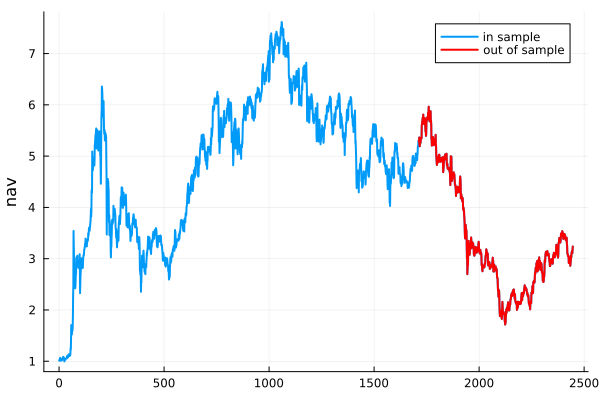

In [26]:
nav = cumprod(1 .+ vec(pnl))
plot(1:length(nav), nav, w=2, label="in sample", ylabel="nav")
plot!(N+1:length(nav), nav[N+1:end], w=2, label="out of sample", c="red")

In [27]:
w

7×2446 Matrix{Float64}:
 5.71959e-6  5.67515e-6  5.54896e-6  …  5.25892e-6  4.73244e-6  5.38253e-6
 0.690501    0.650081    0.70439        0.674601    0.619794    0.666084
 5.79796e-6  5.86631e-6  5.58177e-6     5.37309e-6  4.9627e-6   5.51956e-6
 0.198425    0.215085    0.192354       0.205374    0.226819    0.208846
 1.69656e-5  1.68962e-5  1.64957e-5     1.57409e-5  1.43814e-5  1.60795e-5
 0.111037    0.134797    0.103219    …  0.119991    0.153356    0.125035
 8.51966e-6  8.19511e-6  8.36551e-6     7.75059e-6  6.72699e-6  7.87356e-6